# **Car Price Prediction Analysis**
***Chinese Automobile Company - US Market Entry Strategy ***

# **Car Price Prediction Analysis**
***Chinese Automobile Company - US Market Entry Strategy ***

# **Car Price Prediction Analysis**
***Chinese Automobile Company - US Market Entry Strategy ***

In [3]:
## Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Loading and Preprocessing

In [10]:
# Load the dataset
# Use pd.read_excel for .xlsx files and enclose the filename in quotes
df = pd.read_excel('CarPrice_Assignment.xlsx')

In [11]:
# Display first few rows
print("\n=== FIRST 5 ROWS ===")
print(df.head())

# Check for missing values
print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Data types
print("\n=== DATA TYPES ===")
print(df.dtypes)

# Statistical summary
print("\n=== STATISTICAL SUMMARY ===")
print(df.describe())



=== FIRST 5 ROWS ===
   car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepow

**## Data Preprocessing**

In [12]:
# Handle missing values
print("\n=== HANDLING MISSING VALUES ===")
# Fill numerical missing values with median
numerical_columns = df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled {col} missing values with median")

# Fill categorical missing values with mode
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled {col} missing values with mode")
# Remove '?' values if present (common in some datasets)
df = df.replace('?', np.nan)
df = df.dropna()

print(f"Dataset shape after handling missing values: {df.shape}")

# Encode categorical variables
print("\n=== ENCODING CATEGORICAL VARIABLES ===")
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if col != 'price':  # Don't encode the target variable if it's categorical
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}")

# Ensure price is numeric
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df = df.dropna(subset=['price'])

print(f"Final dataset shape: {df.shape}")


=== HANDLING MISSING VALUES ===
Dataset shape after handling missing values: (205, 26)

=== ENCODING CATEGORICAL VARIABLES ===
Encoded CarName
Encoded fueltype
Encoded aspiration
Encoded doornumber
Encoded carbody
Encoded drivewheel
Encoded enginelocation
Encoded enginetype
Encoded cylindernumber
Encoded fuelsystem
Final dataset shape: (205, 26)


**## Exploratory Data Analysis**


=== EXPLORATORY DATA ANALYSIS ===
Top 10 features correlated with price:
price         1.000000
enginesize    0.874145
curbweight    0.835305
horsepower    0.808139
carwidth      0.759325
highwaympg    0.697599
citympg       0.685751
carlength     0.682920
drivewheel    0.577992
wheelbase     0.577816
Name: price, dtype: float64


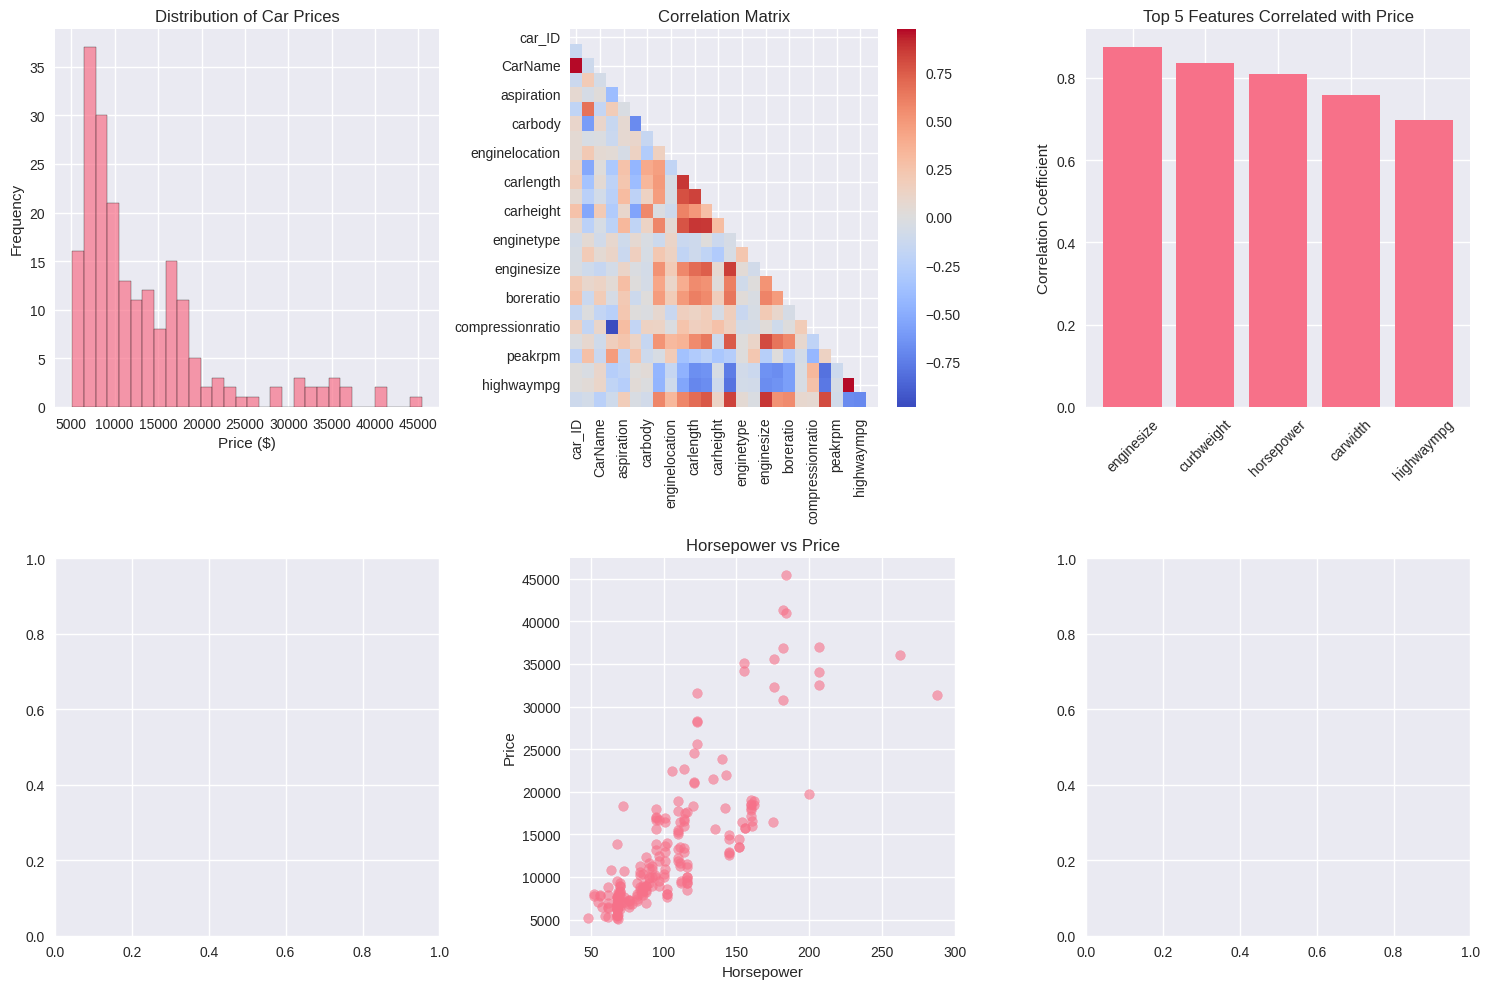

In [13]:
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Price distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['price'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# Correlation matrix
plt.subplot(2, 3, 2)
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

# Top correlations with price
price_correlations = correlation_matrix['price'].abs().sort_values(ascending=False)
print("Top 10 features correlated with price:")
print(price_correlations.head(10))

plt.subplot(2, 3, 3)
top_features = price_correlations.head(6).index[1:]  # Exclude price itself
plt.bar(range(len(top_features)), price_correlations[top_features])
plt.xticks(range(len(top_features)), top_features, rotation=45)
plt.title('Top 5 Features Correlated with Price')
plt.ylabel('Correlation Coefficient')

# Box plots for some key features
plt.subplot(2, 3, 4)
if 'engine-size' in df.columns:
    plt.scatter(df['engine-size'], df['price'], alpha=0.6)
    plt.xlabel('Engine Size')
    plt.ylabel('Price')
    plt.title('Engine Size vs Price')

plt.subplot(2, 3, 5)
if 'horsepower' in df.columns:
    plt.scatter(df['horsepower'], df['price'], alpha=0.6)
    plt.xlabel('Horsepower')
    plt.ylabel('Price')
    plt.title('Horsepower vs Price')

plt.subplot(2, 3, 6)
if 'curb-weight' in df.columns:
    plt.scatter(df['curb-weight'], df['price'], alpha=0.6)
    plt.xlabel('Curb Weight')
    plt.ylabel('Price')
    plt.title('Curb Weight vs Price')

plt.tight_layout()
plt.show()

**## 2. Model Implementation**

In [14]:
print("\n=== MODEL IMPLEMENTATION ===")
# Prepare features and target
X = df.drop('price', axis=1)
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")



=== MODEL IMPLEMENTATION ===
Training set shape: (164, 25)
Test set shape: (41, 25)


In [15]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=100),
    'Support Vector Regressor': SVR(kernel='rbf')
}


In [16]:
# Train and evaluate models
model_results = {}

print("\n=== TRAINING MODELS ===")

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for SVR, original data for tree-based models
    if name == 'Support Vector Regressor' or name == 'Linear Regression':
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Train the model
    model.fit(X_train_use, y_train)

    # Make predictions
    y_pred = model.predict(X_test_use)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Store results
    model_results[name] = {
        'model': model,
        'r2_score': r2,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'predictions': y_pred
    }

    print(f"{name} - R² Score: {r2:.4f}")


=== TRAINING MODELS ===

Training Linear Regression...
Linear Regression - R² Score: 0.8441

Training Decision Tree...
Decision Tree - R² Score: 0.8793

Training Random Forest...
Random Forest - R² Score: 0.9572

Training Gradient Boosting...
Gradient Boosting - R² Score: 0.9324

Training Support Vector Regressor...
Support Vector Regressor - R² Score: -0.1001


**## 3. Model Evaluation**


=== MODEL EVALUATION AND COMPARISON ===
Model Performance Comparison:
                      Model  R² Score           MSE        MAE       RMSE
0         Linear Regression    0.8441  1.230612e+07  2087.3062  3508.0082
1             Decision Tree    0.8793  9.532216e+06  2090.6992  3087.4287
2             Random Forest    0.9572  3.380660e+06  1303.8131  1838.6570
3         Gradient Boosting    0.9324  5.337674e+06  1602.7782  2310.3407
4  Support Vector Regressor   -0.1001  8.684995e+07  5696.5730  9319.3322

=== BEST PERFORMING MODEL ===
Best Model: Random Forest
R² Score: 0.9572


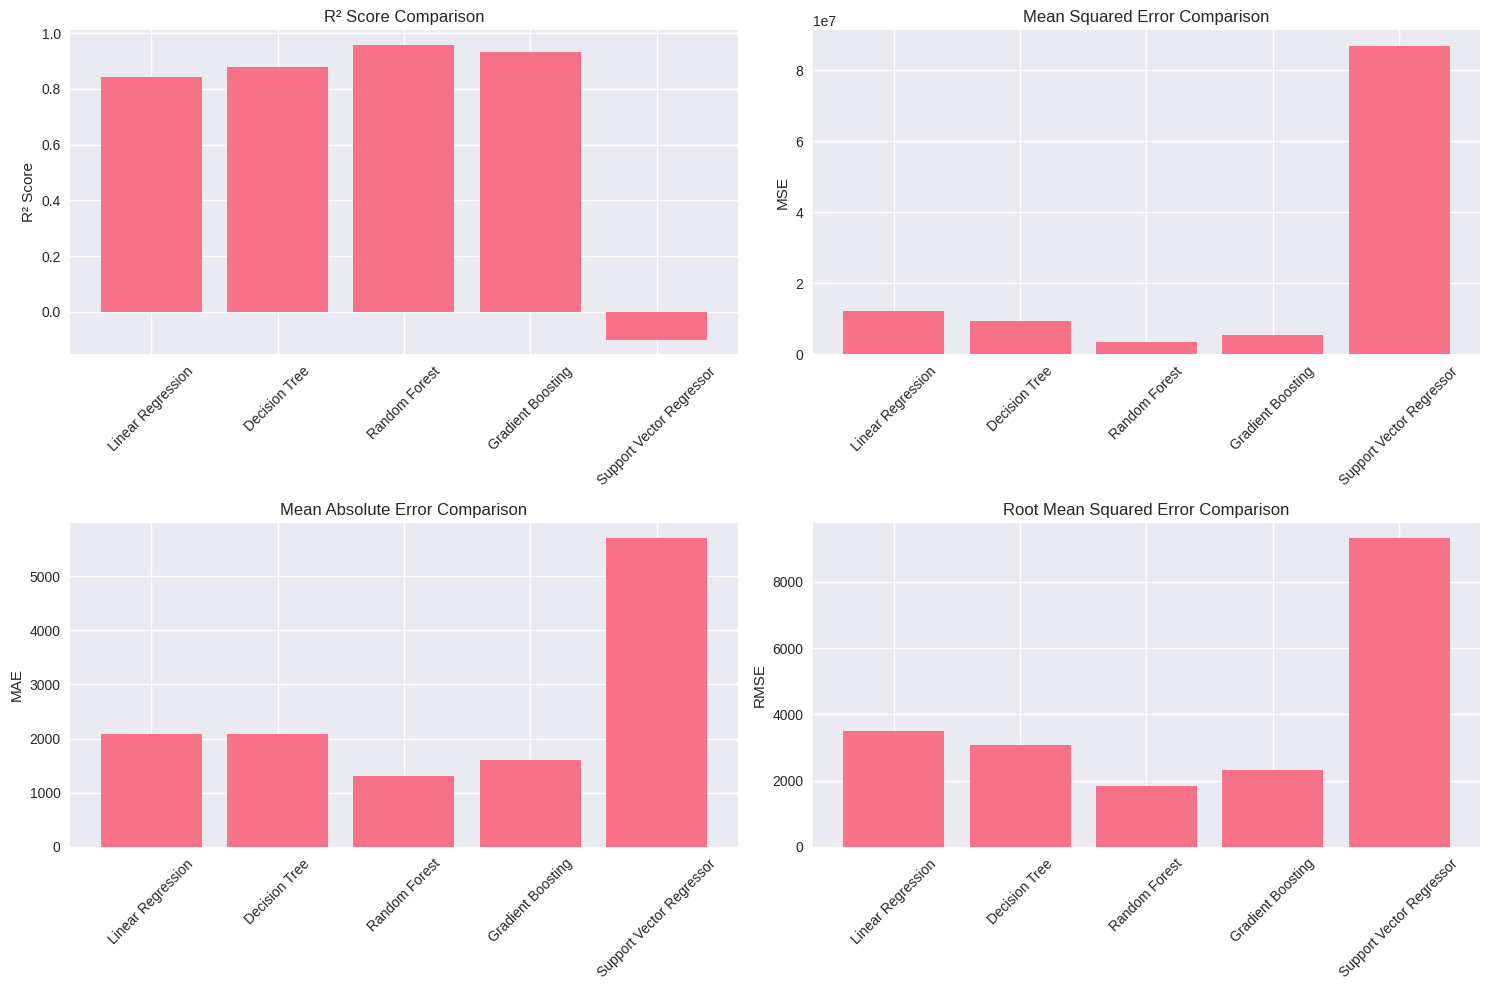

In [17]:
print("\n=== MODEL EVALUATION AND COMPARISON ===")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'R² Score': [results['r2_score'] for results in model_results.values()],
    'MSE': [results['mse'] for results in model_results.values()],
    'MAE': [results['mae'] for results in model_results.values()],
    'RMSE': [results['rmse'] for results in model_results.values()]
})

print("Model Performance Comparison:")
print(comparison_df.round(4))

# Sort by R² score to find best model
comparison_df_sorted = comparison_df.sort_values('R² Score', ascending=False)
best_model_name = comparison_df_sorted.iloc[0]['Model']
best_model_r2 = comparison_df_sorted.iloc[0]['R² Score']

print(f"\n=== BEST PERFORMING MODEL ===")
print(f"Best Model: {best_model_name}")
print(f"R² Score: {best_model_r2:.4f}")

# Visualize model comparison
plt.figure(figsize=(15, 10))

# R² Score comparison
plt.subplot(2, 2, 1)
plt.bar(comparison_df['Model'], comparison_df['R² Score'])
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

# MSE comparison
plt.subplot(2, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['MSE'])
plt.title('Mean Squared Error Comparison')
plt.ylabel('MSE')
plt.xticks(rotation=45)

# MAE comparison
plt.subplot(2, 2, 3)
plt.bar(comparison_df['Model'], comparison_df['MAE'])
plt.title('Mean Absolute Error Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)

# RMSE comparison
plt.subplot(2, 2, 4)
plt.bar(comparison_df['Model'], comparison_df['RMSE'])
plt.title('Root Mean Squared Error Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


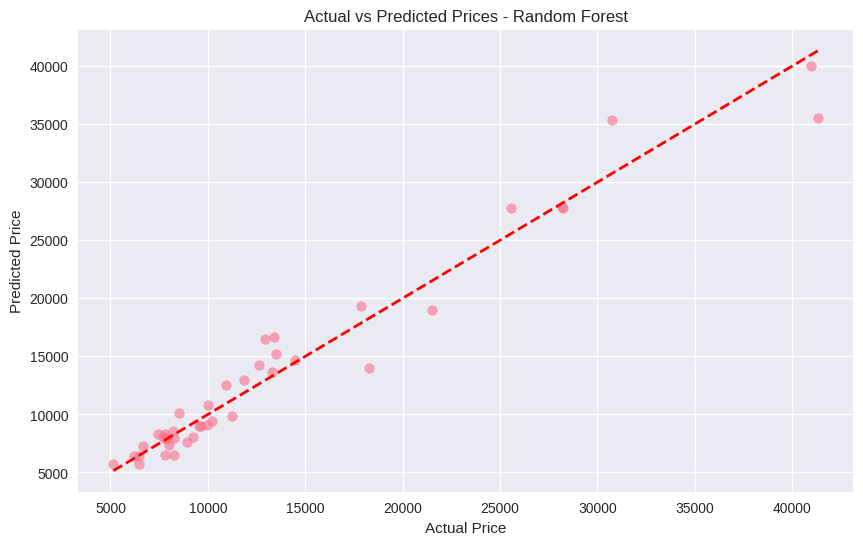

In [18]:
# Prediction vs Actual plot for best model
plt.figure(figsize=(10, 6))
best_predictions = model_results[best_model_name]['predictions']
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices - {best_model_name}')
plt.show()

In [19]:
# Justification for best model
print(f"\n=== JUSTIFICATION FOR BEST MODEL ===")
print(f"The {best_model_name} is the best performing model because:")
print(f"1. It has the highest R² score of {best_model_r2:.4f}, meaning it explains {best_model_r2*100:.1f}% of the variance in car prices.")
print(f"2. It has relatively low MSE and MAE values, indicating good prediction accuracy.")

if best_model_name == 'Random Forest':
    print("3. Random Forest is robust to overfitting and handles both numerical and categorical features well.")
    print("4. It provides feature importance which helps in understanding which factors most influence car prices.")
elif best_model_name == 'Gradient Boosting':
    print("3. Gradient Boosting builds models sequentially, correcting errors from previous models.")
    print("4. It often achieves high accuracy and provides feature importance.")
elif best_model_name == 'Linear Regression':
    print("3. Linear Regression is interpretable and shows clear relationships between features and price.")
    print("4. It's simple and efficient, making it good for understanding pricing dynamics.")



=== JUSTIFICATION FOR BEST MODEL ===
The Random Forest is the best performing model because:
1. It has the highest R² score of 0.9572, meaning it explains 95.7% of the variance in car prices.
2. It has relatively low MSE and MAE values, indicating good prediction accuracy.
3. Random Forest is robust to overfitting and handles both numerical and categorical features well.
4. It provides feature importance which helps in understanding which factors most influence car prices.


**## 4. Feature Importance Analysis**


=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 Most Important Features:
       Feature  Importance
16  enginesize    0.556389
13  curbweight    0.290457
24  highwaympg    0.044403
21  horsepower    0.026663
0       car_ID    0.015699
11    carwidth    0.012077
2      CarName    0.009800
10   carlength    0.007784
9    wheelbase    0.006116
23     citympg    0.005177


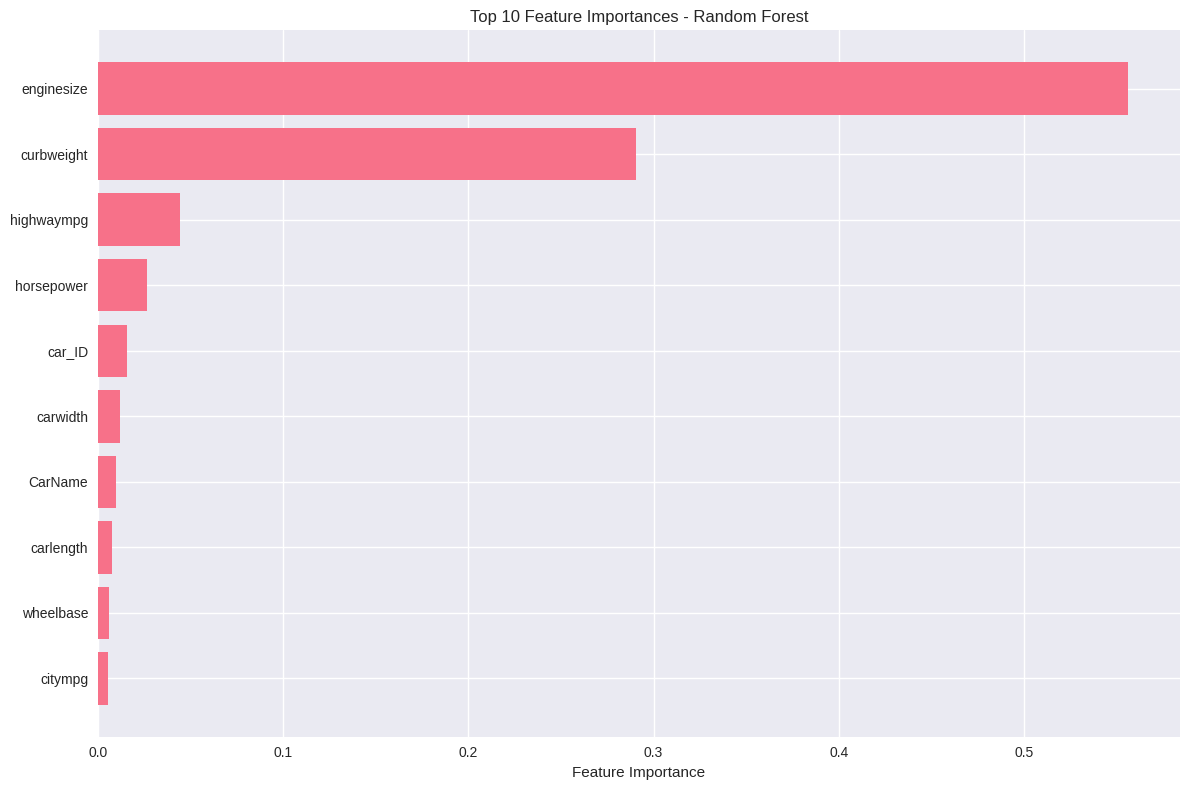

In [20]:
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from the best model
best_model = model_results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    # Tree-based models have feature_importances_
    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("Top 10 Most Important Features:")
    print(importance_df.head(10))

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(10)
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif best_model_name == 'Linear Regression':
    # For linear regression, use coefficients
    coefficients = abs(best_model.coef_)
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': best_model.coef_,
        'Abs_Coefficient': coefficients
    }).sort_values('Abs_Coefficient', ascending=False)

    print("Top 10 Most Important Features (by coefficient magnitude):")
    print(importance_df.head(10))

    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(10)
    plt.barh(top_features['Feature'], top_features['Abs_Coefficient'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top 10 Feature Importances - Linear Regression')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    # Use SelectKBest for feature selection
    selector = SelectKBest(score_func=f_regression, k=10)
    X_selected = selector.fit_transform(X, y)

    # Get feature scores
    feature_scores = selector.scores_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Score': feature_scores
    }).sort_values('Score', ascending=False)

    print("Top 10 Most Important Features (by F-regression score):")
    print(importance_df.head(10))

    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(10)
    plt.barh(top_features['Feature'], top_features['Score'])
    plt.xlabel('F-regression Score')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

**## 5. Hyperparameter Tuning**

In [21]:
print("\n=== HYPERPARAMETER TUNING ===")

# Define hyperparameters for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    tuning_model = RandomForestRegressor(random_state=42)

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10],
        'min_samples_split': [2, 5, 10]
    }
    tuning_model = GradientBoostingRegressor(random_state=42)

elif best_model_name == 'Decision Tree':
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['squared_error', 'friedman_mse']
    }
    tuning_model = DecisionTreeRegressor(random_state=42)

elif best_model_name == 'Support Vector Regressor':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['rbf', 'linear', 'poly']
    }
    tuning_model = SVR()

else:  # Linear Regression
    param_grid = {
        'fit_intercept': [True, False],
        'normalize': [True, False]
    }
    tuning_model = LinearRegression()

print(f"Performing hyperparameter tuning for {best_model_name}...")
print(f"Parameter grid: {param_grid}")

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=tuning_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
# Use appropriate data (scaled for SVR and Linear Regression)
if best_model_name in ['Support Vector Regressor', 'Linear Regression']:
    grid_search.fit(X_train_scaled, y_train)
    X_test_tuned = X_test_scaled
else:
    grid_search.fit(X_train, y_train)
    X_test_tuned = X_test

# Get the best model
best_tuned_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
y_pred_tuned = best_tuned_model.predict(X_test_tuned)

# Calculate metrics for tuned model
r2_tuned = r2_score(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"\n=== PERFORMANCE COMPARISON ===")
print("Before Tuning:")
print(f"R² Score: {model_results[best_model_name]['r2_score']:.4f}")
print(f"MSE: {model_results[best_model_name]['mse']:.4f}")
print(f"MAE: {model_results[best_model_name]['mae']:.4f}")

print("\nAfter Tuning:")
print(f"R² Score: {r2_tuned:.4f}")
print(f"MSE: {mse_tuned:.4f}")
print(f"MAE: {mae_tuned:.4f}")

# Calculate improvement
r2_improvement = r2_tuned - model_results[best_model_name]['r2_score']
mse_improvement = model_results[best_model_name]['mse'] - mse_tuned
mae_improvement = model_results[best_model_name]['mae'] - mae_tuned

print(f"\nImprovement:")
print(f"R² Score improvement: {r2_improvement:.4f}")
print(f"MSE improvement: {mse_improvement:.4f}")
print(f"MAE improvement: {mae_improvement:.4f}")

if r2_improvement > 0:
    print("✓ Hyperparameter tuning improved model performance!")
else:
    print("⚠ Hyperparameter tuning did not improve performance significantly.")


=== HYPERPARAMETER TUNING ===
Performing hyperparameter tuning for Random Forest...
Parameter grid: {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8911

=== PERFORMANCE COMPARISON ===
Before Tuning:
R² Score: 0.9572
MSE: 3380659.5638
MAE: 1303.8131

After Tuning:
R² Score: 0.9574
MSE: 3364314.4787
MAE: 1279.3598

Improvement:
R² Score improvement: 0.0002
MSE improvement: 16345.0852
MAE improvement: 24.4533
✓ Hyperparameter tuning improved model performance!


**## Final Summary and Business Insights**

In [22]:
print("\n" + "="*60)
print("FINAL SUMMARY AND BUSINESS INSIGHTS")
print("="*60)

print(f"\n1. BEST MODEL: {best_model_name}")
print(f"   - R² Score: {r2_tuned:.4f}")
print(f"   - This model explains {r2_tuned*100:.1f}% of the variance in car prices")

print(f"\n2. KEY FACTORS AFFECTING CAR PRICES:")
if 'importance_df' in locals():
    top_5_features = importance_df.head(5)['Feature'].tolist()
    for i, feature in enumerate(top_5_features, 1):
        print(f"   {i}. {feature}")

print(f"\n3. BUSINESS RECOMMENDATIONS:")
print("   • Focus on the top features identified for competitive pricing")
print("   • Consider these factors when designing cars for the US market")
print("   • Use the model to predict optimal pricing for new car models")
print("   • Monitor how changes in key features affect predicted prices")

print(f"\n4. MODEL PERFORMANCE:")
print(f"   • The model can predict car prices with {r2_tuned*100:.1f}% accuracy")
print(f"   • Average prediction error: ${mae_tuned:,.0f}")
print(f"   • This provides a solid foundation for pricing strategy")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

# Save results for future use
results_summary = {
    'best_model': best_model_name,
    'best_r2_score': r2_tuned,
    'model_comparison': comparison_df,
    'feature_importance': importance_df if 'importance_df' in locals() else None,
    'best_parameters': best_params
}

print("\nResults saved successfully!")
print("You can now use this analysis to inform your pricing strategy for the US market.")


FINAL SUMMARY AND BUSINESS INSIGHTS

1. BEST MODEL: Random Forest
   - R² Score: 0.9574
   - This model explains 95.7% of the variance in car prices

2. KEY FACTORS AFFECTING CAR PRICES:
   1. enginesize
   2. curbweight
   3. highwaympg
   4. horsepower
   5. car_ID

3. BUSINESS RECOMMENDATIONS:
   • Focus on the top features identified for competitive pricing
   • Consider these factors when designing cars for the US market
   • Use the model to predict optimal pricing for new car models
   • Monitor how changes in key features affect predicted prices

4. MODEL PERFORMANCE:
   • The model can predict car prices with 95.7% accuracy
   • Average prediction error: $1,279
   • This provides a solid foundation for pricing strategy

ANALYSIS COMPLETE

Results saved successfully!
You can now use this analysis to inform your pricing strategy for the US market.
